We model a region of pixel intensities using the multivariate normal distribution. We begin by making a maximum likelihood fit of a normal distribution to the cracked/uncracked pixels.

$$
\text{Pr}(\mathbf{x}|w = k) = \text{Norm}_{\mathbf{x}}(\mu_k, \Sigma_k)
$$

$$
    \hat{\Sigma} = \frac{1}{I}\sum_{i = 1}^{I}(\mathbf{x}_i - \mu_k)(\mathbf{x}_i - \mu_k)^T \quad \mathbf{x}_i \in\mathcal{S}_k
$$

$$
    \hat{\mu}_k = \frac{1}{I}\sum_{i=1}^I\mathbf{x}_i \quad \mathbf{x}_i \in \mathcal{S}_k
$$

Where $I$ is the number of datapoints in the set of pixels $\mathcal{S}_k$ of class $k$ (i.e. cracked/uncracked).

For inference, we use a Bernoulli prior. The parameter of this prior is sigmoidal mapping of a linear function in the neighborhood's maximum likelihood crack probability densities $\text{Pr}(\mathbf{x}|w = k)$.
$$
    \text{Pr}(w = k|\mathcal{S}_N) = \lambda_k = \frac{1}{1 + \exp[\phi^T p_{N}])}
$$
where $p_N$ is the vector of neighboring crack probabilities:
$$
    p_N =  \begin{bmatrix}
                \text{Pr}_{x_{N1}}(w = 1 \ | \ \mathcal{S}_{N1})\\
                \vdots \\
                \text{Pr}_{x_{NN}}(w = 1 \ | \ \mathcal{S}_{NN})
           \end{bmatrix} 
$$

and $\mathcal{S_{N1}}$ is the set of neighboring pixels for the first neighboring pixel of the current pixel (yikes get some notation).

Now, each step of posterior inference is:

$$
\text{Pr}(w = k|\mathcal{S}_n) \quad \propto \quad \text{Pr}(\mathbf{x} \ | \ w = k, \mathcal{S}_N) \cdot \text{Pr}(w = k \ | \ p_N)
$$

In [1]:
import matplotlib.pyplot as plt
from skimage import morphology
from skimage.transform import resize
from scipy.misc import imread
import numpy as np
import pickle
from tqdm import tqdm
import glob

%matplotlib inline

In [2]:
def data_is_aligned(image_filepaths, mask_filepaths):
    image_ids = [s.split('\\')[-1][:-4] for s in image_filepaths]
    mask_ids = [s.split('\\')[-1][:-4] for s in mask_filepaths]
    return mask_ids == image_ids

# Import images
image_filepaths = glob.glob('.\\data\\resized-images\*.png')
mask_filepaths  = glob.glob('.\\data\\annotated-images-masks\\*.png')
images          = np.array([255 - imread(fp) for fp in image_filepaths])
masks           = np.array([imread(fp) for fp in mask_filepaths])

assert data_is_aligned(image_filepaths, mask_filepaths)

In [587]:
from skimage import exposure
from scipy.ndimage.filters import convolve

def image_filter(image):
    image = image/255.
    fltr = {}
    fltr['line1'] = np.flip(np.eye(size), 0)
    fltr['line2'] = np.eye(size)
    cross_filtered = (convolve(image, fltr['line1']) + convolve(image, fltr['line2']))
    cross_filtered = exposure.rescale_intensity(cross_filtered, out_range='uint8').astype(np.uint8)
    fltr['vert'] = np.zeros([10, 10])
    fltr['vert'][int(fltr['vert'].shape[1]/2), :] = 1
    fltr['hor'] = np.zeros([10, 10])
    fltr['hor'][:, int(fltr['hor'].shape[1]/2)] = 1
    gradients_v = filters.rank.gradient(cross_filtered, fltr['vert'])
    gradients_h = filters.rank.gradient(gradients_v, fltr['hor'])
    return gradients_h

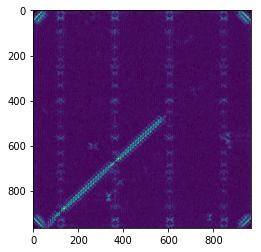

In [597]:
plt.imshow(image_filter(images[9]));

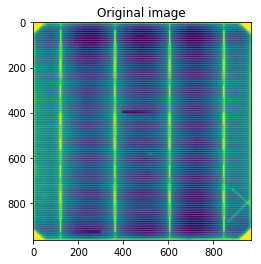

In [549]:
# Preprocessing
sample_image = images[17]/255

fltr = {}
size = 20
fltr['cross'] = (np.flip(np.eye(size), 0) + np.eye(size)> 0).astype(int)
fltr['line1'] = np.flip(np.eye(size), 0)
fltr['line2'] = np.eye(size)

plt.imshow(sample_image); plt.title('Original image');

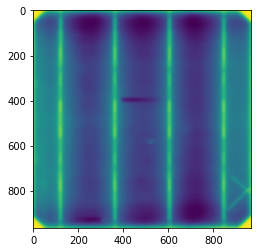

In [550]:
cross_filtered = (convolve(sample_image, fltr['line1']) + convolve(sample_image, fltr['line2']))
cross_filtered = exposure.rescale_intensity(cross_filtered, out_range='uint8').astype(np.uint8)
plt.imshow(cross_filtered);

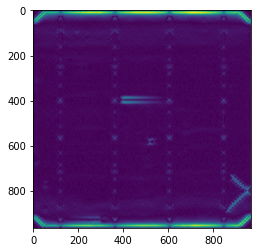

In [559]:
gradients_h = filters.rank.gradient(cross_filtered, fltr['hor'])
plt.imshow(gradients_h);

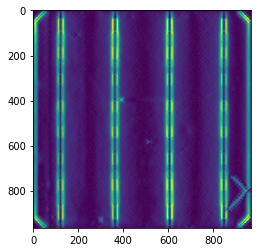

In [560]:
gradients_v = filters.rank.gradient(cross_filtered, fltr['vert'])
plt.imshow(gradients_v);

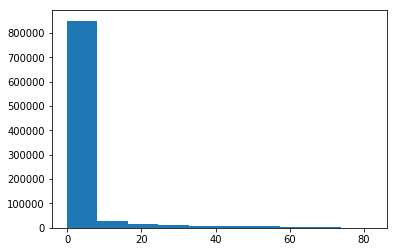

In [561]:
plt.hist(gradients_h.flatten());

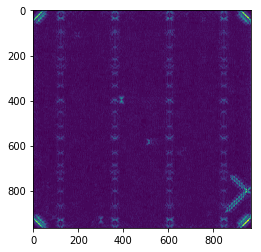

In [563]:
gradients_h = filters.rank.gradient(gradients_v, fltr['hor'])
plt.imshow(gradients_h);

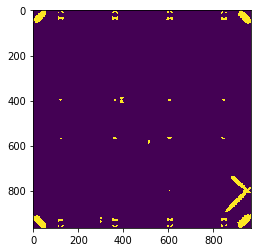

In [568]:
plt.imshow(filters.rank.modal(gradients_h > 8, morphology.disk(5)));

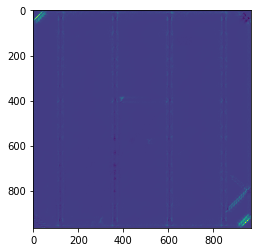

In [569]:
gradients_d = filters.rank.gradient(cross_filtered, np.eye(5));
gradients2 = filters.rank.gradient(gradients, fltr['line1'])
plt.imshow(gradients_h*(gradients_d*1. - gradients2*1.));

C:\Users\admin\Anaconda3\lib\site-packages\skimage\util\dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


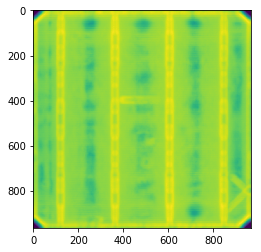

In [578]:
entropy = filters.rank.entropy(sample_image, disk(15))
plt.imshow(entropy);

In [3]:
# Use description
#----------------
# 1. Feed in an image/set of pixels to classifier.
# 2. Classifier evaluates the probability that each pixel corresponds to a crack.
# 3. Classifier returns a heatmap of crack probabilities.

# Model detail
#--------------
# 2.1. Classifier evaluates the likelihood that a pixel was drawn from the crack distribution using the normal. (fixed probabilities)
# 2.2. Classifier sets initial priors equal to (a) base rate, (b) 0.5
# 2.3. Classifier loops over all pixels:
#    2.3.1. Collects the adjacent pixel 'crack' probabilities.
#    2.3.2. Fits the gradient parameter across all pixels using maximum likelihood.
#    2.3.3. Computes each pixel's updated prior based on this fit.
#    2.3.4. Computes the new posterior class membership probability.
#    2.3.5. Iteration stops when the probabilities stop changing.
# 2.4. Return the image of pixel membership probabilities.

# Other Stuff
#--------------
# - Neighborhood morphology.
# - Is it necessary to update the gradient parameters each time?
# - What update pattern encourages most rapid convergence?
# - How do the class priors affect convergence?
# - Do other distributions for the likelihood/prior result in a better fit?
# - Is it optimal to use the same morphology for the pixel intensities as for the pixel probabilities?

# An animation would be nice!

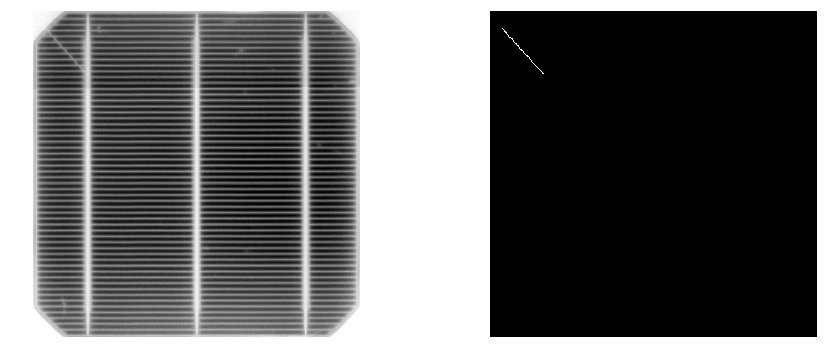

In [108]:
# Display images from
f, axs = plt.subplots(1, 2, figsize = (15, 6))
axs[0].imshow(images[0], cmap = 'gray'); axs[0].axis('off')
axs[1].imshow(masks[0], cmap = 'gray'); axs[1].axis('off');

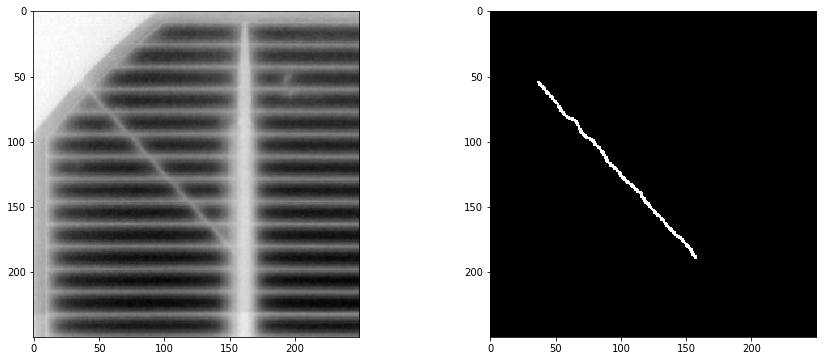

In [5]:
# How big's that crack?
f, axs = plt.subplots(1, 2, figsize = (15, 6))
axs[0].imshow(images[0][0:250, 0:250], cmap = 'gray') 
axs[1].imshow(masks[0][0:250, 0:250], cmap = 'gray');

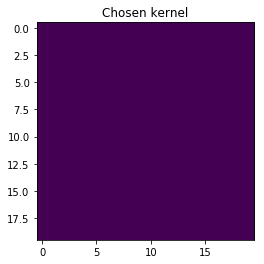

In [7]:
kernel = morphology.square(20)
plt.imshow(kernel); plt.title('Chosen kernel');

In [8]:
def hadamard_kernel(image, ix_c, kernel):
    # Returns the hadamard product of the kernel with the image, centered on (ix_c[0], ix_c[1])
    k_w          = kernel.shape[1]  # Kernel width
    k_h          = kernel.shape[0]  # Kernel height
    image        = np.pad(image, [[k_h, k_h], [k_w, k_w]], mode = 'constant', constant_values = 0)
    image_window = image[ix_c[0] + k_h - np.floor(k_h/2).astype(int) : ix_c[0] + k_h + np.ceil(k_h/2).astype(int),
                         ix_c[1] + k_w - np.floor(k_w/2).astype(int) : ix_c[1] + k_w + np.ceil(k_w/2).astype(int)]
    return image_window*kernel

def random_choice(matrix, n):
    # Rows of matrix correspond to samples
    # n random rows are returned
    rnd_ix = np.random.randint(0, matrix.shape[0], n)
    return matrix[rnd_ix, :].squeeze()

def scale_images(images): # Scale images after taking their kernels - it's faster!
    return (images/128) - 0.5

def normal_ML_fit(X, diag = False):
    mu = np.mean(X, axis = 0)
    Sigma = (np.mat(X - mu.T).T * np.mat(X - mu.T)/X.shape[0])
    if diag: Sigma = np.diag(Sigma) * np.eye(mu.shape[0])
    return mu, Sigma

In [9]:
# Classifier evaluates the likelihood that a pixel was from a normal distribution of cracked pixel intensities.
# -> Fit a normal distribution for crack intensities.

# How to describe the neighborhood?
training_set_size = 3000
img_shape    = images[0, :, :].shape
n_rows       = images.shape[0]*int(img_shape[0]*img_shape[1]*0.005)
n_features   = kernel.shape[0]*kernel.shape[1]
n_images     = images.shape[0]
X   = { 'crack'   : np.zeros([n_rows, n_features]),
        'nocrack' : np.zeros([n_rows, n_features]) } # X contains matrices whose rows are pixel intensity neighborhoods

crack_ix   = np.array(np.nonzero(masks != 0)).T
nocrack_ix = np.array(np.nonzero(masks == 0)).T

X['crack']   = np.array([hadamard_kernel(images[ix[0]], ix[1:], kernel).flatten() 
                                        for ix in random_choice(crack_ix, training_set_size)])
X['nocrack'] = np.array([hadamard_kernel(images[ix[0]], ix[1:], kernel).flatten()
                                        for ix in random_choice(nocrack_ix, training_set_size)])

X['crack']   = scale_images(X['crack'][np.any(X['crack'] != 0, axis = 1)])
X['nocrack'] = scale_images(X['nocrack'][np.any(X['nocrack'] != 0, axis = 1)])
        
print('Pixel neighborhood vectors successfully created and scaled.')        

Pixel neighborhood vectors successfully created and scaled.


In [10]:
# Now calculate the multivariate mean and covariance matrix for each of these pixel neighborhoods
mu = {}; Sigma = {}

# We take the maximum likelihood values (full covariance matrix)
mu['crack'], Sigma['crack']     = normal_ML_fit(X['crack'], diag = True)
mu['nocrack'], Sigma['nocrack'] = normal_ML_fit(X['nocrack'], diag = True)
print('Calculated intensity distribution parameters successfully.')

Calculated intensity distribution parameters successfully.


The multivariate normal distribution should describe a crack. Let's take a look at the average crack pixel neighborhood.

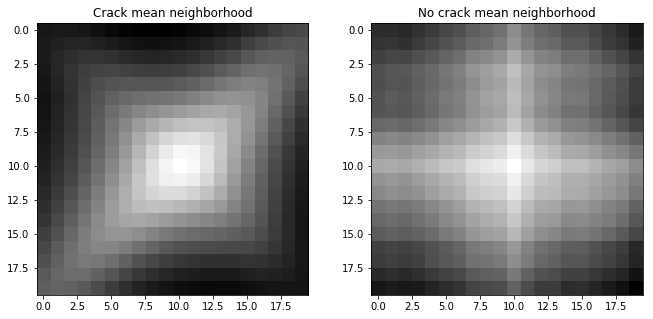

In [11]:
f, axs = plt.subplots(1, 2, figsize = (11, 5))
axs[0].imshow(mu['crack'].reshape(kernel.shape), cmap = 'gray'); axs[0].set_title('Crack mean neighborhood')
axs[1].imshow(mu['nocrack'].reshape(kernel.shape), cmap = 'gray'); axs[1].set_title('No crack mean neighborhood');

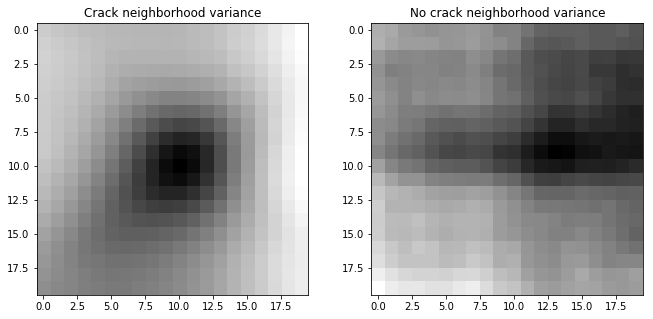

In [12]:
f, axs = plt.subplots(1, 2, figsize = (11, 5))
axs[0].imshow(np.diag(Sigma['crack']).reshape(kernel.shape), cmap = 'gray');
axs[0].set_title('Crack neighborhood variance')
axs[1].imshow(np.diag(Sigma['nocrack']).reshape(kernel.shape), cmap = 'gray');
axs[1].set_title('No crack neighborhood variance');

Now what we need to do is to set up the neighborhood probability density calculations.

1. Fit logistic regression gradients to a subset of the data.
2. Get the likelihoods for each pixel using the normal distribution we set up above.
3. Get the neighborhood priors using the logistic fit.
4. Compute the posterior by taking their normalized product.

In [13]:
def dnorm(X, mu, Sigma, diag = False, log = False):
    # X has rows corresponding to samples
    assert mu.shape[0]     == Sigma.shape[0]
    assert Sigma.shape[0]  == Sigma.shape[1]
    assert X.shape[-1]     == mu.shape[0]
    
    D = mu.shape[0];
    X = np.mat(X); mu = np.mat(mu).T; Sigma = np.mat(Sigma);
    
    if not diag:
        raise ValueError('Covariance matrix must be diagonal.')
        #det = np.linalg.det(Sigma)
        #inv = np.linalg.inv(Sigma)
    if diag:
        log_det = np.sum(np.log(np.diag(Sigma)))
        inv = np.mat(np.diag(1/np.diag(Sigma)))
    
    if log:
        log_probs = -0.5 * ( D*np.log(2*np.pi)   +   log_det  +  (X - mu.T) * inv * (X - mu.T).T)
        return np.array(np.diag(log_probs)).squeeze()
    else:
        raise ValueError('dnorm() can only return log-probabilities at the moment.')

In [15]:
def get_image_likelihoods(image, kernel, mu, Sigma):
    crack_likelihood   = np.zeros(image.shape)
    nocrack_likelihood = np.zeros(image.shape) 
    for row in tqdm(range(image.shape[0])):
            patches = np.array([hadamard_kernel(image, [row, col], kernel).flatten()
                                    for col in range(image.shape[1])])
            crack_likelihood[row, :]   = dnorm(patches, mu['crack'], Sigma['crack'], diag = True, log = True)
            nocrack_likelihood[row, :] = dnorm(patches, mu['nocrack'], Sigma['nocrack'], diag = True, log = True)
    return crack_likelihood, nocrack_likelihood

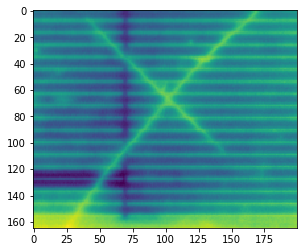

In [109]:
training_image = images[8][800:, 250:450]
training_labels = masks[8][800:, 250:450].flatten()
plt.imshow(training_image);

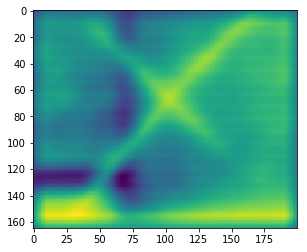

In [17]:
# Compute likelihoods at all points in sample image
log_cl, log_ncl = get_image_likelihoods(training_image, kernel, mu, Sigma)

# Compute the posterior
prior = {}; posterior = {};
prior['crack']   = 0.5
prior['nocrack'] = 1 - prior['crack']

log_odds           = log_cl + np.log(prior['crack']) - (log_ncl + np.log(prior['nocrack']))
plt.imshow(log_odds);

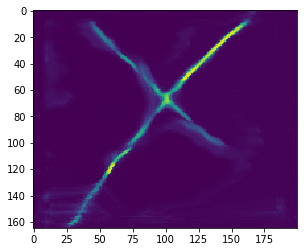

In [69]:
from sklearn.ensemble import RandomForestClassifier

train_log_odd_vectors  = np.array([hadamard_kernel(log_odds, [row, col], kernel).flatten() 
                                     for row in range(log_odds.shape[0]) for col in range(log_odds.shape[1])])

rfc = RandomForestClassifier(n_estimators = 50, max_depth = 6)
rfc.fit(train_log_odd_vectors, labels)
plt.imshow(rfc.predict_proba(train_log_odd_vectors)[:, 1].reshape(log_odds.shape));

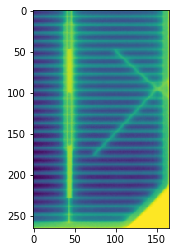

In [65]:
valid_image  = scale_images(images[45][700:, 800:])
valid_labels = masks[45][700:, 800:]
plt.imshow(sample_image_2);

100%|████████████████████████████████████████| 265/265 [00:27<00:00, 10.35it/s]


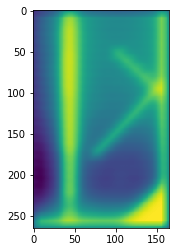

In [66]:
# Compute likelihoods at all points in sample image
log_cl, log_ncl = get_image_likelihoods(valid_image, kernel, mu, Sigma)

# Compute the posterior
prior = {}; posterior = {};
prior['crack']   = 0.5
prior['nocrack'] = 1 - prior['crack']

valid_log_odds           = log_cl + np.log(prior['crack']) - (log_ncl + np.log(prior['nocrack']))
plt.imshow(valid_log_odds);

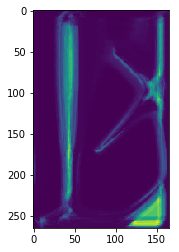

In [70]:
valid_log_odd_vectors  = np.array([hadamard_kernel(valid_log_odds, [row, col], kernel).flatten() 
                                      for row in range(valid_log_odds.shape[0]) for col in range(valid_log_odds.shape[1])])

plt.imshow(rfc.predict_proba(valid_log_odd_vectors)[:, 1].reshape(valid_log_odds.shape));